# Calculate the stationary internal tide component

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --ntasks=16 -c 16 start_worker.slm scheduler-$HOSTNAME.json ./"`


In [11]:
!echo $(hostname)

nid002024


In [12]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + 'nid002024' + '.json')
client

<Client: 'tcp://10.253.133.4:8786' processes=16 threads=256, memory=429.92 GiB>

In [35]:
client.restart() # This clears all data

<Client: 'tcp://10.253.133.4:8786' processes=16 threads=256, memory=429.92 GiB>

In [14]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

In [15]:
s3login = '/home/mrayson/code/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [36]:
# f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr/", s3=s3)
# varname = 'eta_steric_bandpass'

f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr/", s3=s3)
varname = 'eta_bandpass'


ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:       (Nc: 225368, numsides: 8, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time          (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r           (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells         (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv            (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz            (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta           (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    eta_bandpass  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    eta_lowpass   (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    eta_tidal     (time, Nc) float64 dask.array<chunksize=(8761, 1000), meta=np.ndarray>
    nfaces        (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    xp            (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv            (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp            (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv            (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

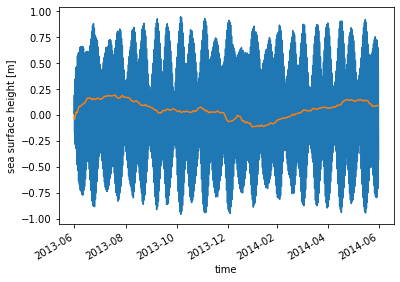

In [18]:
ds['eta_bandpass'].isel(Nc=10000).plot()
ds['eta_lowpass'].isel(Nc=10000).plot()


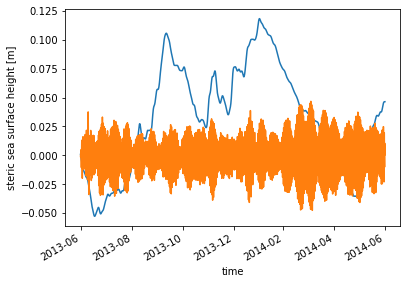

In [11]:
# ds['eta_steric_lowpass'].isel(Nc=10000).plot()
# ds['eta_steric_bandpass'].isel(Nc=10000).plot()

In [21]:
# ds['eta_steric_tidal'].isel(Nc=10000).plot()
# (ds['eta_steric_bandpass'].isel(Nc=10000)-ds['eta_steric_tidal'].isel(Nc=10000)).plot()

# ds['eta_tidal'].isel(Nc=10000).plot()
# (ds['eta_bandpass'].isel(Nc=10000)-ds['eta_tidal'].isel(Nc=10000)).plot()

In [22]:
import sfoda.utils.harmonic_analysis as ha
from sfoda.utils.othertime import SecondsSince
from datetime import datetime
import dask


In [23]:
def build_lhs_dask(t,frq):
    """
    Construct matrix A
    """
    nt=t.shape[0]
    frq = np.array(frq)
    
    nf=frq.shape[0]
    nff=nf*2+1
    A=np.ones((nt,nff))
    for ff in range(0,nf):
        A[:,ff*2+1]=np.cos(frq[ff]*t)
        A[:,ff*2+2]=np.sin(frq[ff]*t)

    return dask.array.from_array(A, chunks=(A.shape[0],A.shape[1]))

def lstsq_dask(A,y):    
    """    
    Solve the least square problem

    Return:
        the complex amplitude 
        the mean
    """
    N=A.shape[1]
    b,res,rank,s = dask.array.linalg.lstsq(A,y)

    return b


def harmonic_fit_dask(X, t, omega):
           
    A = build_lhs_dask(t, omega)

    
    #print('A: ',A.shape)
    
    # Remove NaNs
    #X[dask.array.isnan(X)] = 0.

    # Least-squares matrix approach
    b = lstsq_dask(A, X) # This works on all columns of X!!
    #print('b', b.shape)

    return b

twopi = 2*np.pi
tdaysec = 86400.
def nonstat_harmonic_fit_dask(X, t, omega, na, omega_A=twopi/(365*tdaysec)):
    frq_all =[]
    for ff in omega:
        for n in range(-na,na+1):
            frq_all.append(ff+n*omega_A)

    Y = harmonic_fit_dask(X, t, frq_all)
    aa = Y[0,...]
    Aa = Y[1::2,...]
    Ba = Y[2::2,...]
    
    return aa, Aa, Ba, frq_all

In [25]:
# Do the harmonic fits
reftime = datetime(1990,1,1)
freq_list = ['M2','S2','N2','K2','K1','O1','P1','Q1']
frq, names = ha.getTideFreq(freq_list)
time = SecondsSince(ds.time.values, basetime=reftime)
na = 0 # Number of annual harmonics to include
# aa, Aa, Ba, frq_all = nonstat_harmonic_fit_dask(ds['eta_steric_bandpass'], time, frq, na)
aa, Aa, Ba, frq_all = nonstat_harmonic_fit_dask(ds['eta_bandpass'], time, frq, na)

/opt/conda/lib/python3.10/site-packages/dask/array/core.py:3339: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


In [26]:
Aa

dask.array<getitem, shape=(8, 225368), dtype=float64, chunksize=(8, 1000), chunktype=numpy.ndarray>

In [27]:
def harmonic_pred_dask(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = dask.array.ones_like(tdays)[:,None] * aa
    for ii in range(nomega):
        amp += Aa[ii,...]*np.cos(omega[ii]*tdays)[:,None] + Ba[ii,...]*np.sin(omega[ii]*tdays)[:,None]
    
    return amp

In [28]:
eta_steric_tidal = harmonic_pred_dask(aa, Aa, Ba, frq_all, time)
eta_steric_tidal

dask.array<add, shape=(8761, 225368), dtype=float64, chunksize=(8761, 1000), chunktype=numpy.ndarray>

In [30]:
# # Create an output data set
# dsout = ds.drop_vars(['eta_steric_lowpass','eta_steric_bandpass'])

# dsout['eta_steric_tidal'] = xr.DataArray(eta_steric_tidal, dims=('time','Nc'), 
#                                            attrs=
#                                 {'long_name':'steric sea surface height','units':'m','location':'face',
#                                 'tidal frequencies':freq_list} )
# dsout

# Create an output data set
dsout = ds.drop_vars(['eta_lowpass','eta_bandpass'])

dsout['eta_tidal'] = xr.DataArray(eta_steric_tidal, dims=('time','Nc'), 
                                           attrs=
                                {'long_name':'steric sea surface height','units':'m','location':'face',
                                'tidal frequencies':freq_list} )


dsout

<xarray.Dataset>
Dimensions:    (time: 8761, Nc: 225368, numsides: 8, Nk: 80, Np: 454016)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r        (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells      (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv         (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz         (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta        (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    nfaces     (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    xp         (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv         (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp         (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv         (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    eta_tidal  (time, Nc) float64 dask.array<chunksize=(8761, 1000), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [31]:
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr'
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr'

dsout.to_zarr(outfile, mode='a', append_dim=None, compute=True)


In [32]:
# Save time chunked output
# d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr", s3=s3)
d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr", s3=s3)

dsout.to_zarr(store=d, mode='a', compute=True, safe_chunks=False)

In [38]:
from sfoda.utils.myproj import MyProj
# Convert the coordinates
P=MyProj('merc')


In [39]:
# Chunk along space and re-save
ds_c = ds
ds_c['cells']= xr.where(ds.cells==999999, -999999, ds.suntans.cells)

ds_c['xv'][:], ds_c['yv'][:] = P.to_xy(ds['xv'], ds['yv'])
ds_c['xp'][:], ds_c['yp'][:] = P.to_xy(ds['xp'], ds['yp'])

ds_c = ds_c.chunk({'Nc':-1,'time':96})
ds_c#, ds_c['cells'].values


<xarray.Dataset>
Dimensions:       (Nc: 225368, numsides: 8, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time          (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r           (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells         (Nc, numsides) int32 dask.array<chunksize=(225368, 8), meta=np.ndarray>
    dv            (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    dz            (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta           (time, Nc) float64 dask.array<chunksize=(96, 225368), meta=np.ndarray>
    eta_bandpass  (time, Nc) float64 dask.array<chunksize=(96, 225368), meta=np.ndarray>
    eta_lowpass   (time, Nc) float64 dask.array<chunksize=(96, 225368), meta=np.ndarray>
    eta_tidal     (time, Nc) float64 dask.array<chunksize=(96, 225368), meta=np.ndarray>
    nfaces        (Nc) int32 dask.array<chunksize=(225368,), meta=np.ndarray>
    xp            (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv            (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    yp            (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv            (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [40]:
# ds_c['eta_steric_bandpass'].encoding['chunks']={'chunks':(96,225368) }
# ds_c['eta_steric_bandpass'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
# ds_c['eta_steric_lowpass'].encoding['chunks']={'chunks':(96,225368) }
# ds_c['eta_steric_lowpass'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
# ds_c['eta_steric_tidal'].encoding['chunks']={'chunks':(96,225368) }
# ds_c['eta_steric_tidal'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
# ds_c['eta_steric_bandpass'].encoding

ds_c['eta_bandpass'].encoding['chunks']={'chunks':(96,225368) }
ds_c['eta_bandpass'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
ds_c['eta_lowpass'].encoding['chunks']={'chunks':(96,225368) }
ds_c['eta_lowpass'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
ds_c['eta_tidal'].encoding['chunks']={'chunks':(96,225368) }
ds_c['eta_tidal'].encoding['preferred_chunks']={'time': 96, 'Nc': 225368},
ds_c['eta_bandpass'].encoding

{'chunks': {'chunks': (96, 225368)},
 'preferred_chunks': ({'time': 96, 'Nc': 225368},),
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64')}

In [41]:
# Save time chunked output
# d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_spacechunk.zarr", s3=s3)
d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_spacechunk.zarr", s3=s3)

ds_c.to_zarr(store=d, mode='w', compute=True, safe_chunks=False)

In [45]:
client.restart()

<Client: 'tcp://10.253.133.4:8786' processes=30 threads=480, memory=806.09 GiB>